Session Calculation strategy:

- Costruct and load data into Pandas DataFrames
- Group data by users
- Sort timestamps within each user groups
- For each user
    - Capture first session start time
    - Capture session end time
    - Session time = Start time -  end time
    - Check if next start times are before 30 seconds of further stop times
        - Yes : Continue session
        - No : Reset session
    - Store valid sessions ( < 1 seconds )in list for each user along with sdk version for the user

In [106]:
#Author: Amit M Shankarikoppa
#Date created: 2nd May 2017

#make sure to install these python packages before running the code
import pandas as pd
import numpy as np
import re
import itertools
from collections import OrderedDict
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

In [107]:
# reads data from log and returns Dataframe object
def getData():
    df = pd.read_csv('ggevent.log', header=None, delimiter=',',
                       names='ai5 debug random sdkv event ts params timestamp game_id'.split(), parse_dates= True)
    timestampSeries = df.timestamp.apply(lambda x: x.split(':',2)[-1].replace("\"", ""))
    logFrame = df.applymap(lambda x: x.replace("{","").replace("}","").replace("\"","").split(":")[-1])
    logFrame['timestamp'] = timestampSeries
    logFrame['timestamp'] = pd.to_datetime(logFrame['timestamp'])
    
    # group data based on user ID or ai5 and sort timestamps for each user
    groupedData = logFrame.sort_values(['ai5', 'timestamp'], ascending = [True, True]).reset_index()
    groupedData = groupedData.drop('index', axis = 1)
    finalData = [group.reset_index() for _, group in groupedData.groupby('ai5')]
    return finalData

In [108]:
# # Algorithm to calculate sessions for each user, returns dictionary with key as user id and value as list of sessions
# # Algorithm uses looping, enhancements can be done using pandas dataframe way(complicated but effecient).

def loopedSessionCalculator(finalDataFrame):
    loopedSessionCalculator.session_dict = {}
    for group in finalDataFrame:
        loopedSessionCalculator.start_index = 0
        loopedSessionCalculator.stop_index = 0
        loopedSessionCalculator.session_time = 0
        loopedSessionCalculator.new_session = True
        loopedSessionCalculator.sdkwise = {}
        for i in range(len(group.index)):
            session_started = False
            loopedSessionCalculator.session_dict.setdefault(group.ix[0].ai5,[group.ix[0].sdkv])
            # identify the start of session
            if('ggstart' in group.ix[i].event):
                sessrion_started = True
                
                if(i > 1):
                    inter_sessionTime =  pd.Timedelta(group.ix[loopedSessionCalculator.stop_index].timestamp - group.ix[loopedSessionCalculator.start_index].timestamp).seconds
                    
                    if(inter_sessionTime < 30):
                        loopedSessionCalculator.new_session = False
               
                loopedSessionCalculator.start_index = i
            #identify stop of session (consecutive starts and stops are identified to be valid)
            elif('ggstop' in group.ix[i].event and sessrion_started):
                session_started = False
                loopedSessionCalculator.stop_index = i;
                loopedSessionCalculator.session_stop = group.ix[i].timestamp
                loopedSessionCalculator.session_time += pd.Timedelta(group.ix[i].timestamp - group.ix[loopedSessionCalculator.start_index].timestamp).seconds
            
            if(loopedSessionCalculator.session_time > 1 and not session_started and loopedSessionCalculator.new_session):
                loopedSessionCalculator.session_dict[group.ix[0].ai5].append(loopedSessionCalculator.session_time)
                loopedSessionCalculator.session_time = 0
                loopedSessionCalculator.new_session = True
            
                
    return loopedSessionCalculator.session_dict

In [109]:
#main code snippet
finalData = getData()
sessionDict = loopedSessionCalculator(finalData)
sessionFrame = pd.DataFrame([sessionDict]).transpose()
sessionFrame = pd.DataFrame([sessionDict]).transpose()
sessionFrame.rename(columns= {0:'Sessions'}, inplace = True)
sessionFrame['sdkv'] = sessionFrame['Sessions'].apply(lambda x: x[0])
sessionFrame['Sessions'] = sessionFrame['Sessions'].apply(lambda x: x[1:])
#Create column for number of sessions for each user id
sessionFrame['Number_of_sessions'] = sessionFrame['Sessions'].apply(lambda x: len(x))
# Extract valied sessions from all sessions
sessionFrame['Valid_sessions'] = sessionFrame['Sessions'].apply(lambda x: sum(1 for i in x if i > 60))
#Calculate average of valid sessions
sessionFrame['Average_valid'] = sessionFrame['Sessions'].apply(lambda x: (sum(i for i in x if i > 60) / sum(1 for i in x if i > 60)) if sum(1 for i in x if i > 60) > 0 else 0)

In [110]:
sessionFrame

,Sessions,sdkv,Number_of_sessions,Valid_sessions,Average_valid
000523f72f16359e9962fd25c825eebf,[],7.6,0,0,0.000000
00057368e3db67e8db27dc415209cc92,"[113, 230, 156, 165, 26]",7.6,5,4,166.000000
0006df67ddcf576f4d38edd46c10b5a1,[13],7.5.1,1,0,0.000000
00071e48377752c551d9ecda33c55945,[12],7.5.1,1,0,0.000000
000c6c4d3976e75a32d422bdda89f9e5,"[305, 5]",7.6,2,1,305.000000
000d2688374c44397a3f94dd975cffb4,[87],7.6,1,1,87.000000
000e3141a0b69405f75c877396a988ba,"[385, 59, 21]",7.6,3,1,385.000000
00129e2c2eeb77cd45de41d5e8440934,"[225, 150]",7.6,2,2,187.500000
00145d2801465edb6be8cacbc0e12052,[36],7.6,1,0,0.000000
0017e70ebdfdca2662c8892f811e5c66,[],7.6,0,0,0.000000


Number of Valid Sessions summary statistics:
count    17419.000000
mean         1.520581
std          2.848888
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         33.000000
Name: Valid_sessions, dtype: float64
Valid Average Session values summary statistics:
count    7843.00000
mean      221.02737
std       253.17136
min        61.00000
25%       111.06250
50%       147.00000
75%       210.00000
max      3418.00000
Name: Average_valid, dtype: float64


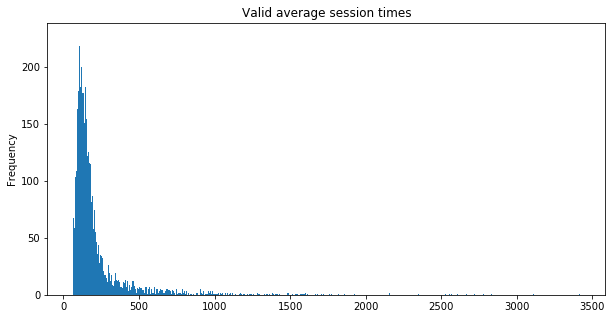

In [111]:
print("Number of Valid Sessions summary statistics:")
print(sessionFrame.Valid_sessions.describe())
#sessionFrame.Valid_sessions.hist(grid = False)
print("Valid Average Session values summary statistics:")
print(sessionFrame[sessionFrame['Average_valid'] > 0].Average_valid.describe())
sessionFrame[sessionFrame['Average_valid'] > 0].Average_valid.plot(kind= 'hist',bins= 1000,
                                                                   figsize = (10,5),
                                                                   title ='Valid average session times')


Users' valid sessions are on an average of 221 seconds ranging from 61 to 3418 seconds. In the given data average valid session per user is about 1.5.
The distribution of average user session times is not normal. It is skewed to the right. The standard deviation also stands high at 253 seconds higher than the mean time of 221 seconds.
The sample needs to be normalised to make further analysis on the data.

Bar chart of Total Basket Sizes with Total Basket Prices


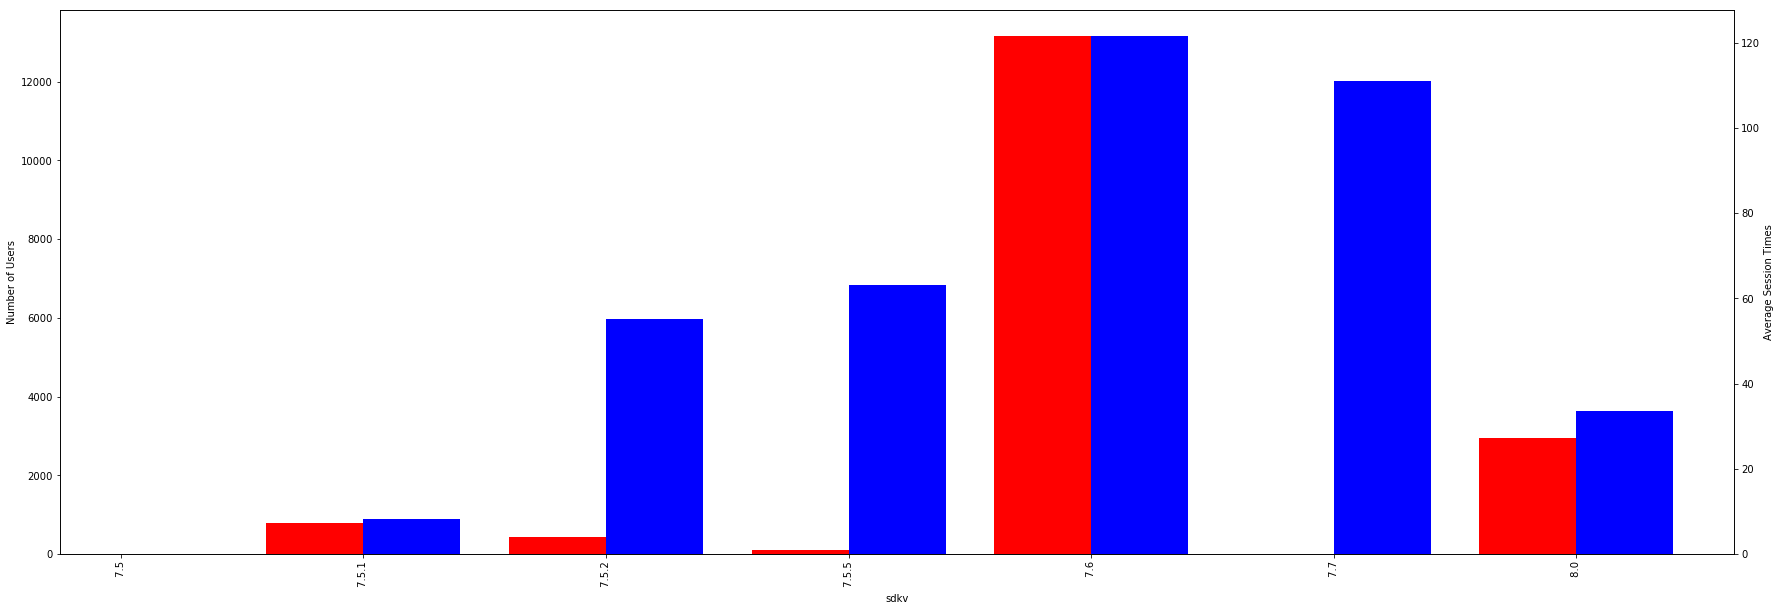

,Number_of_users,Total_time,Average_session_time
sdkv,,,
7.5,2,0.000000e+00,0.000000
7.5.1,797,6.557500e+03,8.227729
7.5.2,427,2.356597e+04,55.189617
7.5.5,94,5.941050e+03,63.202660
7.6,13150,1.598015e+06,121.522052
7.7,1,1.110000e+02,111.000000
8.0,2948,9.932717e+04,33.693069


In [133]:
# group users by sdk versions and get average session times spent in different sdk versions
sdkDataFrame = sessionFrame.groupby('sdkv')['Average_valid'].agg(['count','sum','mean'])
sdkDataFrame.rename(columns= {'count':'Number_of_users','sum':'Total_time','mean':'Average_session_time'}, inplace = True)

#plot bar chart to identify the difference in the contributions of different basketsizes in overall profit
fig = plt.figure(figsize=(30,10)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.4
sdkDataFrame.Number_of_users.plot(kind='bar', color='red', ax=ax, width=width, position=1)
sdkDataFrame.Average_session_time.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
ax.set_ylabel('Number of Users')
ax2.set_ylabel('Average Session Times')
print("Bar chart of Total Basket Sizes with Total Basket Prices")
plt.show()
sdkDataFrame

The bar chart provides insights about session times of users of different sdk versions.
It is clear that the highest unmber of users are using sdk version of 7.6 and also they have the highest session average.
The transtion to next sdk version (8.0) is happening and the users are spending more time playing the game in this version as well.
Users with sdk versions 7.5 barely exist and there are no identifiable valid sessions for these users.
Transition of sdk version seems to be happening from 7.7 to directly 8.0 rather than through 7.7.

Discrepancies in data and work arounds:

- Given log data might have missing start timestamps and stop timestamps. The algorithm consideres the consecutive start and stop(in that order) to calculate the session times.
- The recorded time stamps might be out of order. The algorithm first sorts the data in the increasing order of timestamos to solve this problem.
- Data type discrepancies are directly handled by Pandas Dataframe construction.
- Given data has many missing values. Improving the quality of data could provide better results.